# Aplicando Análise de Sentimentos Utilizando um Classificador Naive Bayes

In [188]:
import nltk
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import cross_val_predict

In [189]:
dataset = pd.read_csv('Tweets_Mg.csv', encoding='utf-8')

In [190]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8199 entries, 0 to 8198
Data columns (total 26 columns):
Unnamed: 0                   8199 non-null int64
Created At                   8199 non-null object
Text                         8199 non-null object
Geo Coordinates.latitude     104 non-null float64
Geo Coordinates.longitude    104 non-null float64
User Location                5489 non-null object
Username                     8199 non-null object
User Screen Name             8199 non-null object
Retweet Count                8199 non-null int64
Classificacao                8199 non-null object
Observação                   1 non-null object
Unnamed: 10                  0 non-null float64
Unnamed: 11                  0 non-null float64
Unnamed: 12                  0 non-null float64
Unnamed: 13                  0 non-null float64
Unnamed: 14                  0 non-null float64
Unnamed: 15                  0 non-null float64
Unnamed: 16                  0 non-null float64
Unnamed: 17 

In [191]:
#expande o tamanho de exibição da coluna de texto
pd.set_option('display.max_colwidth', -1)
dataset.Text.head(100)

0     ���⛪ @ Catedral de Santo Antônio - Governador Valadares/MG https://t.co/JSbKamIqUJ                                                         
1     � @ Governador Valadares, Minas Gerais https://t.co/B3ThIDJCSf                                                                             
2     �� @ Governador Valadares, Minas Gerais https://t.co/dPkgzVR2Qw                                                                            
3     ��� https://t.co/BnDsO34qK0                                                                                                                
4     ��� PSOL vai questionar aumento de vereadores e prefeito de BH na Justiça - Politica - Estado de Minas https://t.co/DMg7BGsek5             
                                                                   ...                                                                           
95    #noticiasdorenan Uso de depósitos judiciais pelo governo tem nova polêmica em MG: O Banco… https://t.co/kHuZpKQaj5    

In [192]:
dataset.count()

Unnamed: 0                   8199
Created At                   8199
Text                         8199
Geo Coordinates.latitude     104 
Geo Coordinates.longitude    104 
User Location                5489
Username                     8199
User Screen Name             8199
Retweet Count                8199
Classificacao                8199
Observação                   1   
Unnamed: 10                  0   
Unnamed: 11                  0   
Unnamed: 12                  0   
Unnamed: 13                  0   
Unnamed: 14                  0   
Unnamed: 15                  0   
Unnamed: 16                  0   
Unnamed: 17                  0   
Unnamed: 18                  0   
Unnamed: 19                  0   
Unnamed: 20                  0   
Unnamed: 21                  0   
Unnamed: 22                  0   
Unnamed: 23                  0   
Unnamed: 24                  0   
dtype: int64

In [193]:
#excluir linhas duplicadas
dataset.drop_duplicates(['Text'], inplace=True)

In [194]:
dataset.count()

Unnamed: 0                   5765
Created At                   5765
Text                         5765
Geo Coordinates.latitude     104 
Geo Coordinates.longitude    104 
User Location                3851
Username                     5765
User Screen Name             5765
Retweet Count                5765
Classificacao                5765
Observação                   1   
Unnamed: 10                  0   
Unnamed: 11                  0   
Unnamed: 12                  0   
Unnamed: 13                  0   
Unnamed: 14                  0   
Unnamed: 15                  0   
Unnamed: 16                  0   
Unnamed: 17                  0   
Unnamed: 18                  0   
Unnamed: 19                  0   
Unnamed: 20                  0   
Unnamed: 21                  0   
Unnamed: 22                  0   
Unnamed: 23                  0   
Unnamed: 24                  0   
dtype: int64

In [195]:
#removendo colunas desnecessarias
for i in dataset.columns.values:
    if i.startswith('Unnamed'):
        dataset.drop(i, axis=1, inplace=True)
        print("Colunas deletadas")

Colunas deletadas
Colunas deletadas
Colunas deletadas
Colunas deletadas
Colunas deletadas
Colunas deletadas
Colunas deletadas
Colunas deletadas
Colunas deletadas
Colunas deletadas
Colunas deletadas
Colunas deletadas
Colunas deletadas
Colunas deletadas
Colunas deletadas
Colunas deletadas


In [196]:
dataset.columns

Index(['Created At', 'Text', 'Geo Coordinates.latitude',
       'Geo Coordinates.longitude', 'User Location', 'Username',
       'User Screen Name', 'Retweet Count', 'Classificacao', 'Observação'],
      dtype='object')

In [197]:
dataset.Classificacao.unique()

array(['Neutro', 'Negativo', 'Positivo'], dtype=object)

### Distribuição das classes neutros, positivos e negativos

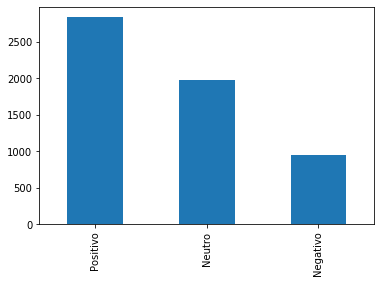

In [198]:
%matplotlib inline
dataset.Classificacao.value_counts().plot(kind='bar')

### Separando tweets e suas classes

In [199]:
twetts = dataset.Text
classes = dataset.Classificacao

In [200]:
twetts.head()

0    ���⛪ @ Catedral de Santo Antônio - Governador Valadares/MG https://t.co/JSbKamIqUJ                                            
1    � @ Governador Valadares, Minas Gerais https://t.co/B3ThIDJCSf                                                                
2    �� @ Governador Valadares, Minas Gerais https://t.co/dPkgzVR2Qw                                                               
3    ��� https://t.co/BnDsO34qK0                                                                                                   
4    ��� PSOL vai questionar aumento de vereadores e prefeito de BH na Justiça - Politica - Estado de Minas https://t.co/DMg7BGsek5
Name: Text, dtype: object

In [201]:
classes.head()

0    Neutro  
1    Neutro  
2    Neutro  
3    Neutro  
4    Negativo
Name: Classificacao, dtype: object

### Gerando o modelo

In [202]:
#transformando o texto em uma lista de vetores binarios
vectorizer = CountVectorizer(analyzer="word")
freq_tweets = vectorizer.fit_transform(twetts)

In [203]:
type(freq_tweets)

scipy.sparse.csr.csr_matrix

In [204]:
freq_tweets.shape

(5765, 13029)

In [205]:
#imprimindo uma matrix com a frequencia de cada palavra na base
freq_tweets.A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### Criando um modelo usando o Naive Bayes Multinomial

In [206]:
modelo = MultinomialNB()

In [207]:
modelo.fit(freq_tweets, classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Testando o modelo com algumas instâncias simples


In [208]:
# defina instâncias de teste dentro de uma lista
testes = ['Esse governo está no início, vamos ver o que vai dar',
          'Estou muito feliz com o governo de Minas esse ano',
          'O estado de Minas Gerais decretou calamidade financeira!!!',
          'A segurança desse país está deixando a desejar',
          'O governador de Minas é mais uma vez do PT']

In [209]:
#transforma os dados de teste em vetores de palavras
freq_testes = vectorizer.transform(testes)

In [210]:
type(freq_testes)

scipy.sparse.csr.csr_matrix

In [211]:
freq_testes.A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [212]:
freq_testes.shape

(5, 13029)

In [213]:
for t, c in zip (testes, modelo.predict(freq_testes)):
    print(t +", "+c)

Esse governo está no início, vamos ver o que vai dar, Neutro
Estou muito feliz com o governo de Minas esse ano, Neutro
O estado de Minas Gerais decretou calamidade financeira!!!, Negativo
A segurança desse país está deixando a desejar, Neutro
O governador de Minas é mais uma vez do PT, Neutro


In [214]:
#probabilidades de cada classe
print(modelo.classes_)
modelo.predict_proba(freq_testes).round(2)

['Negativo' 'Neutro' 'Positivo']


array([[0.18, 0.82, 0.  ],
       [0.02, 0.98, 0.  ],
       [0.99, 0.01, 0.  ],
       [0.1 , 0.89, 0.01],
       [0.15, 0.85, 0.  ]])

### Avaliação do Modelo

In [215]:
resultados = cross_val_predict(modelo, freq_tweets, classes, cv=10)

In [216]:
resultados

array(['Neutro', 'Neutro', 'Neutro', ..., 'Positivo', 'Positivo',
       'Positivo'], dtype='<U8')

### Matriz de Confusão

In [217]:
print(pd.crosstab(classes, resultados, rownames=['Real'], colnames=['Predito'], margins=True))

Predito   Negativo  Neutro  Positivo   All
Real                                      
Negativo  846       100     5         951 
Neutro    206       1656    112       1974
Positivo  53        294     2493      2840
All       1105      2050    2610      5765


### Metricas de Avaliação do Modelo

In [218]:
sentimento = ['Positivo', 'Negativo', 'Neutro']
print(metrics.classification_report(classes, resultados, sentimento))

              precision    recall  f1-score   support

    Positivo       0.96      0.88      0.91      2840
    Negativo       0.77      0.89      0.82       951
      Neutro       0.81      0.84      0.82      1974

    accuracy                           0.87      5765
   macro avg       0.84      0.87      0.85      5765
weighted avg       0.87      0.87      0.87      5765

